## Housing Prices Intro ## 

The goal of this project is to predict housing prices, minimizing MSE (mean squared error). This is a regresssion problem and my goal in attempting the challenge is to develop a cross validation pipeling that includes all elements of model creation (including feature selection and hyperparameter tuning).

In the process, I wrote my first Python classes that inheret from the SKlearn Transformer class. While SKlearn pipelines are difficult to inspect, the ability to cross-validate the entire model building process and to simply call the transform method on the test set is invaluable in a production setting and makes data leakage almost impossible. I intend to use these transformers and pipelines in my future projects. 

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
# for testing code snippets
%qtconsole

In [4]:
# Basic EDA plotter: histograms, PDFS, QQ plots and a correlation matrix

def EDA_PLOTTER(cols,df1, df2): 
    import scipy.stats as stats
    import pylab
    
    for each in cols:
#         Hists
        xmax = df1[each].quantile(.995)
        xmin = df1[each].quantile(0)
        x_u = df1[each].quantile(.995)
        x_l = df1[each].quantile(.01)
        df1[each].plot(kind = 'hist',xlim = (xmin,xmax), bins = 500, subplots = True, legend = True)
        plt.axvline(x= x_u, color = 'r')
        plt.axvline(x= x_l, color = 'r')
        plt.xlabel(each)
        tight_layout = True
        plt.show()
        
        #PDFS
        xmax = df1[each].quantile(.995)
        xmin = df1[each].quantile(0)
        x_u = df1[each].quantile(.995)
        x_l = df1[each].quantile(.01)
        df1[each].plot(kind = 'hist', normed = True, cumulative = True, xlim = (xmin,xmax), bins = 500, subplots = True, legend = True )
        plt.axvline(x= x_u, color = 'r')
        plt.axvline(x= x_l, color = 'r')
        tight_layout = True
        plt.xlabel(each)
        plt.show()
        
        #QQ plot
        stats.probplot(df1[each].dropna(), dist = 'norm', plot = pylab)
        plt.title(each)
        pylab.show()
        
    
#     #pairplot
#     sns.pairplot(df1)
#     plt.show()
    
    #heatmap
    corr = df2.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 1, figsize=(40,40))
        ax = sns.heatmap(corr, cmap = 'Blues', linecolor='white', linewidths=1, vmin = -1, vmax = 1, annot = True, mask = mask)
        plt.show()


In [5]:
def null_drop(df, percent):
    cols = list(df.columns)
    df_len = len(df)
    col_drop = []
    for each in cols:
        null_percent = ((df[each].isnull().sum()) / df_len)
        if null_percent >= percent:
            print(str(each), null_percent)
            col_drop.append(each)
    if len(col_drop) == 0:
        return print("None!")
        
    else:
        return [x for x in cols if x not in col_drop]
            

In [6]:
def unique_vals(df):
    cat_cols = list(df.select_dtypes(include=['object']).columns)
    high_mode_cats = []
    [print(df[x].value_counts()) for x in cat_cols]
    for each in cat_cols:
        if df[each].value_counts().max()/ len(df[each]) >= .9:
            high_mode_cats.append(each)
            print("high_mode_cat: ", str(each), df[each].value_counts().max()/ len(df[each]) )
    return cat_cols, high_mode_cats
    

In [7]:
def desc_stats(df):
    print("info: ",df.info())
    print("shape:" , df.shape)
    print("describe: ",df.describe())
    print(df.head(5))
    return 


In [8]:
# Data

house_df = pd.read_csv(r"C:\Users\yi6\Desktop\Housing_Prices\train.csv")

In [9]:
# checking to make sure no nulls in target variable 
# before passing to transformer pipe
house_df.dropna(subset = ['SalePrice'], inplace = True, axis = 0)

non_null = null_drop(df= house_df, percent = .2)
house_df = house_df[non_null]

print(desc_stats(house_df))

Alley 0.9376712328767123
FireplaceQu 0.4726027397260274
PoolQC 0.9952054794520548
Fence 0.8075342465753425
MiscFeature 0.963013698630137
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 76 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
Ro

In [10]:
# most of the columns are unassigned objects. 
# converting to categorical for one hot encoding

cat_cols = list(house_df.select_dtypes(include=['object']).columns)

for each in cat_cols:
    house_df[each] = house_df[each].astype('category')

#also, month sold should be cat, not numeric
#could convert this to a season column...
house_df.MoSold = house_df.MoSold.astype('category') 


In [11]:
# converting categoricals to boolean

house_df = pd.get_dummies(house_df)

In [12]:
#there is one unique ID per house

print(len(house_df.Id.unique()))
print(len(house_df))

# engineering features. more work needs to be done here, but this was not the focus of this particular project.
# I did not include any interaction terms (multiplication, subtraction, etc.) because the feature space is large in comparison
# to the number of rows and I don't want to model noise

house_df['House_Age'] = house_df.YrSold.sub(house_df.YearBuilt)

#split into  feature/response, drop ID col.
X = house_df[[x for x in house_df.columns if x not in ['SalePrice', 'Id']]]
y = house_df[['SalePrice']]

print(list(X.columns),list(y.columns))

1460
1460
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_B

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


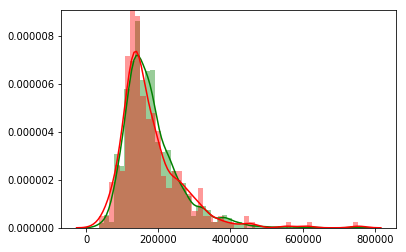

<class 'pandas.core.frame.DataFrame'>


In [13]:
# split data into train/test
# plot train/test dists

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


sns.distplot(y_train, bins=50, norm_hist = True, kde=True, color = 'green')
sns.distplot(y_test, bins=50,norm_hist = True, kde=True, color = 'red')
plt.show()

print(type(X_train))

In [14]:
# This is a custom class I wrote. It regresses each feature on all other in a loop and 
# automatically drops highest correlated features. This continues until a VIF threshold has been reached

class Null_drop(BaseEstimator, TransformerMixin): 
    def __init__(self, thresh):
        self.thresh = thresh
        self.cols = None
        
    def fit(self,X,y=None):
        print(X.shape)
        cols = list(X.columns)
        df_len = len(X)
        col_drop = []
        for each in cols:
            null_percent = ((X[each].isnull().sum()) / df_len)
            if null_percent >= self.thresh:
#                 print(str(each), null_percent)
                col_drop.append(each)
       
        self.cols = [x for x in cols if x not in col_drop]
        print("{} {}".format("cols to drop:", col_drop))
        return self
        
        
    def transform(self,X):
        X = pd.DataFrame(X)
        X= X[self.cols]
#         print(X.info())
        print(X.shape)
        return(X)
        
    

In [15]:
#inspecting class before including in pipe

Null_drop_instance = Null_drop(thresh = .2)
transformed = Null_drop_instance.fit_transform(X_train)
transformed_2 = Null_drop_instance.transform(X_test)

(1168, 282)
cols to drop: []
(1168, 282)
(292, 282)


In [ ]:
from sklearn.base import TransformerMixin

class unique_vals_drop(BaseEstimator, TransformerMixin): 
    def __init__(self, thresh):
        self.thresh = thresh
        self.cols = None
        
    def fit(self,X,y=None):
        print(X.shape)
        high_mode_cats = []
        X = pd.DataFrame(X)
        cols = X.columns
#         [print(X[x].value_counts()) for x in cols]
        print(X.shape)
        for each in cols:
            if X[each].value_counts().max()/ len(X[each]) >= self.thresh:
                high_mode_cats.append(each)
#                 print("high_mode_cat: ", str(each), X[each].value_counts().max()/ len(X[each]) )
        self.cols = [x for x in cols if x not in high_mode_cats]
#         print("{} {}".format("cols to drop:", high_mode_cats))
        return self
        
        
    def transform(self,X):
        if self.thresh is not None:
            print(X.shape)
            X = pd.DataFrame(X)
            X= X[self.cols]
            return(X)
        else:
            X = pd.DataFrame(X)
            return (X)

In [49]:
#inspecting class before including in pipe

unique_vals_drop_instance = unique_vals_drop(thresh = .95)
transformed = unique_vals_drop_instance.fit_transform(X_train)
transformed_2 = unique_vals_drop_instance.transform(X_test)

(1168, 282)
(1168, 282)
(1168, 126)
(292, 126)


In [ ]:
from sklearn.linear_model import LinearRegression
import time

class VIF_drop(BaseEstimator, TransformerMixin):
    def __init__(self, VIF, exclude = None):
        self.VIF = VIF
        self.exclude = exclude
        self.cols = None

        
    def fit(self,X,y=None):
        if self.
        print(X.shape)
        X = pd.DataFrame(X)
        assert isinstance(X, pd.DataFrame)
        start = time.time()
        max_vif = 0
        cols = X.columns
        print(X.columns)
        col_list = [x for x in X if x not in [self.exclude]]
        while max_vif>= self.VIF or len(col_list) > 1:
            VIFs = []
            cols_vif = []
            max_col = np.nan
            
            for each in col_list:
                x = X.drop(each,axis = 1)
                y = X[each]
                model = LinearRegression()
                results = model.fit(x,y)
                VIF = 1/(1-results.score(x,y))
                VIFs.append(VIF)
                cols_vif.append(each)
#                 print(each,": ",VIF)

            max_vif = max(VIFs)
            max_col = cols_vif[VIFs.index(max_vif)]

            if max_vif >= self.VIF:
                col_list.remove(max_col)
#                 print("Removed: ", max_col, max_vif)   

            else: 
                end = time.time()
                print(X.shape)
                elapsed = end - start
#                 print("remaining_cols","{}".format(col_list))
#                 print('Done: ' + str(np.round(elapsed, decimals = 3)) +" " + "seconds")
                self.cols = col_list
                return self
    
    def transform(self,X):
        if self.VIF is not None:
            print(X.shape)
            X = pd.DataFrame(X)
            X= X[self.cols]
            return(X)
        else:
            X = pd.DataFrame(X)
            return (X)
        

In [19]:
#inspecting class before including in pipe

X_train_na = X_train.fillna(method='ffill')
X_train_ints = X_train_na.select_dtypes(include=['int64','float64'])
X_test_na = X_test.fillna(method='ffill')
X_test_ints = X_test_na.select_dtypes(include=['int64','float64'])
VIF_instance = VIF_drop(VIF = 5, exclude = 'Id')
transformed = VIF_instance.fit_transform(X_train_ints)
transformed_2 = VIF_instance.transform(X_test_ints)

(1168, 36)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'YrSold', 'House_Age'],
      dtype='object')


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(1168, 36)
(1168, 36)
(292, 36)


In [20]:
# filters to rows provided in list within pipe 

from sklearn.base import BaseEstimator, TransformerMixin

class ColSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        print(X.shape)
        return self
    def transform(self, X):
        return X[self.cols]

## Regression Pipeline ##

Pipeline Credit:  Kartikay Bagla: Random Forests and Gradient Boosting: https://www.kaggle.com/drvader/random-forests-and-gradient-boosting

This pipeline fits three models: Lasso, Random Forest, and Gradient Boosting. Within each pipeline, the data is split into numeric and categorical (one hot encoded as boolean). Within each sub-pipeline, there is imputation, feature selection, and in the case of numerics, scaling.

The Lasso model (linear with regularization) performs well in comparison to the non-parametric models.
Given its relative simplicity and interpretability, I would be inclined to select this for production as opposed to the others. It is slightly overfit (train/test variance ~= to ~5% of mean house price), but the bias in the test set is low, errors are normally distributed, and there is no heteroskedasticity in the residual plot, so I don't think it is too much of a problem. Note that stacking these models might yield good results and could be tested.

Cross-validating feature selection performed worse than simply dropping features and then cross validating only the hyperparameters. It could be that 200 model fits is not sufficient to converge on the minimum error, or it could be that other methods are appropriate.

In any case, SKlearn pipelines are powerful objects and having the ability to create new custom classes that can be cross-validated is exciting. 

Note that SKlearn tends to return Numpy arrays as opposed to DataFrames, making it difficult to inspect which columns were dropped during cross validation. Further work needs to be done in order to maintain a list of these columns throughout the pipeline process.



In [ ]:
#Final Pipe

import numpy as np
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import Imputer
from sklearn.model_selection import RandomizedSearchCV

######################### Col Select ###############################

numerics = list(X_train.select_dtypes(include=['int64','float64']).columns)
cats = list(X_train.select_dtypes(include=['uint8']).columns)

######################### Lasso Pipe ###############################

lasso_cats = Pipeline([
            ('selector', ColSelector(cols = cats)),
            ('imputer', Imputer(strategy='most_frequent')),
            ('unique_vals_drop', unique_vals_drop(thresh = .95))
          ])

lasso_numerics =  Pipeline([
            ('selector', ColSelector(cols =numerics)),
           ('imputer', Imputer(strategy='mean')),
           ('VIF_drop', VIF_drop(VIF = 5)),
            ('scaler', StandardScaler())
        ])



lasso_transformer = Pipeline([('feats', FeatureUnion([('lasso_cats', lasso_cats), ('lasso_numerics', lasso_numerics)]))])

######################### RF Pipe ##################################

RF_cats = Pipeline([
            ('selector', ColSelector(cols = cats)),
            ('imputer', Imputer(strategy='most_frequent')),
            ('unique_vals_drop', unique_vals_drop(thresh = .95))
          ])

RF_numerics =  Pipeline([
            ('selector', ColSelector(cols =numerics)),
           ('imputer', Imputer(strategy='mean')),
            ('VIF_drop', VIF_drop(VIF = 5)),
            ('scaler', StandardScaler())
        ])

RF_transformer = Pipeline([('feats', FeatureUnion([('RF_numerics', RF_numerics), ('RF_cats', RF_cats)]))])

######################### GB Pipe ##################################    
    
GB_cats = Pipeline([
            ('selector', ColSelector(cols = cats)),
            ('imputer', Imputer(strategy='most_frequent')),
            ('unique_vals_drop', unique_vals_drop(thresh = .95))
          ])

GB_numerics =  Pipeline([
            ('selector', ColSelector(cols =numerics)),
           ('imputer', Imputer(strategy='mean')),
            ('VIF_drop', VIF_drop(VIF = 5)),
            ('scaler', StandardScaler())
        ])


GB_transformer = Pipeline([('feats', FeatureUnion([('GB_numerics', GB_numerics), ('GB_cats', GB_cats)]))])

######################### Grids  ##################################   

lr_grid = { 
      'Lasso__alpha': [.0001,.001,.01,.1, .5, 1 ],
     'pipeline__feats__lasso_cats__unique_vals_drop__thresh': [.9,.95,.99],
      'pipeline__feats__lasso_numerics__VIF_drop__VIF': [5,10,15],
    
    
          }

rf_grid = {   
    "feature_selection__k": [int(x) for x in np.linspace(start = 2, stop = 50, num = 2)],
    'RandomForestRegressor__n_estimators': [int(x) for x in np.linspace(start = 10, stop = 2000, num = 20)],
    'RandomForestRegressor__max_features': ['auto', 'sqrt'],
    'RandomForestRegressor__max_depth': [int(x) for x in np.linspace(5, 20, num = 4)],
    'RandomForestRegressor__min_samples_split': [int(x) for x in np.linspace(10,300, num =30 )],
    'RandomForestRegressor__min_samples_leaf': [int(x) for x in np.linspace(10,300, num =30 )]
#                    'RandomForestClassifier__bootstrap' = [True, False]
    }

gb_grid = {   
    "feature_selection__k": [int(x) for x in np.linspace(start = 2, stop = 50, num = 2)],
    'GradientBoostingRegressor__n_estimators': [int(x) for x in np.linspace(start = 10, stop = 2000, num = 20)],
#     'GradientBoostingRegressor__max_features': ['auto', 'sqrt'],
    'GradientBoostingRegressor__learning_rate':[0.01, 0.025, 0.05, 0.075, 0.1],
    'GradientBoostingRegressor__max_depth': [3,5,7,9,12],
#     'GradientBoostingRegressor__min_samples_split': [int(x) for x in np.linspace(10,300, num =30 )],
    'GradientBoostingRegressor__min_samples_leaf': [int(x) for x in np.linspace(10,300, num =30 )]
#     'GradientBoostingRegressor__criterion': ["friedman_mse",  "mae"],
#     'GradientBoostingRegressor__subsample':[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0]
          }

######################### Pipelines  ##################################        

pipelines = {
    
#     "lr": Pipeline([("pipeline",lasso_transformer), ("Lasso",Lasso(random_state=42))]),
    "rf": Pipeline([("pipeline",RF_transformer),("feature_selection", SelectKBest(f_regression)), ("RandomForestRegressor",RandomForestRegressor(random_state=42,n_jobs = -1))]),
    "gb": Pipeline([("pipeline",GB_transformer),("feature_selection", SelectKBest(f_regression)), ("GradientBoostingRegressor",GradientBoostingRegressor(random_state=42))])
    
          }     

######################### Fitting Models  #############################  

hyperparameters = {
                   "lr": lr_grid,
                   "rf": rf_grid,
                   "gb": gb_grid
          }

fitted_models = {}

for name, pipeline in pipelines.items():
    
    if name == "lr":
        model = GridSearchCV(pipeline, hyperparameters[name], cv= 5)
    else:
        model = RandomizedSearchCV(pipeline, hyperparameters[name], cv= 5,n_iter =200)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted.')

(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)
(234, 36)
(234, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)
(234, 36)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)
(234, 36)
(234, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)
(234, 36)
(234, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)
(233, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)
(234, 36)
(234, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)
(233, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)
(233, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)
(234, 36)
(234, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)
(233, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)
(234, 36)
(234, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(1168, 282)
(1168, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(1168, 36)
(1168, 36)
(1168, 282)
(1168, 246)
(1168, 246)
(1168, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


rf has been fitted.
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)
(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)
(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)
(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
RangeIndex(start=0, stop=36, step=1)
(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)
(234, 36)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars



(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)
(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars



(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)
(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)
(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)
(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)
(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars



(935, 36)
RangeIndex(start=0, stop=36, step=1)
(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)
(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)
(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)
(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)
(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)
(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)
(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)
(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)
(234, 36)
(234, 95)
(934, 36)
(934, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 94)
(234, 36)
(234, 94)
(934, 36)
(934, 94)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 96)
(234, 36)
(234, 96)
(934, 36)
(934, 96)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)


C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


(233, 36)
(233, 95)
(935, 36)
(935, 95)
(935, 282)
(935, 36)
RangeIndex(start=0, stop=36, step=1)
(935, 36)
(935, 36)
(935, 282)
(935, 246)
(935, 246)
(935, 95)
(233, 36)

C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yi6\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars



(233, 95)
(935, 36)
(935, 95)
(934, 282)
(934, 36)
RangeIndex(start=0, stop=36, step=1)
(934, 36)
(934, 36)
(934, 282)
(934, 246)
(934, 246)
(934, 95)


In [35]:
# potential Paramenters to tune

print(pipeline.get_params().keys())


dict_keys(['memory', 'steps', 'pipeline', 'Lasso', 'pipeline__memory', 'pipeline__steps', 'pipeline__feats', 'pipeline__feats__n_jobs', 'pipeline__feats__transformer_list', 'pipeline__feats__transformer_weights', 'pipeline__feats__lasso_numerics', 'pipeline__feats__lasso_cats', 'pipeline__feats__lasso_numerics__memory', 'pipeline__feats__lasso_numerics__steps', 'pipeline__feats__lasso_numerics__selector', 'pipeline__feats__lasso_numerics__imputer', 'pipeline__feats__lasso_numerics__VIF_drop', 'pipeline__feats__lasso_numerics__scaler', 'pipeline__feats__lasso_numerics__selector__cols', 'pipeline__feats__lasso_numerics__imputer__axis', 'pipeline__feats__lasso_numerics__imputer__copy', 'pipeline__feats__lasso_numerics__imputer__missing_values', 'pipeline__feats__lasso_numerics__imputer__strategy', 'pipeline__feats__lasso_numerics__imputer__verbose', 'pipeline__feats__lasso_numerics__VIF_drop__VIF', 'pipeline__feats__lasso_numerics__VIF_drop__exclude', 'pipeline__feats__lasso_numerics__sca

In [54]:
# error analysis

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

for name, model in fitted_models.items():
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    test_resid = y_test.values.reshape(292,) - pred_test
    print(name)
    print('RMSE_train:',  np.round(np.sqrt(mean_squared_error(y_train, pred_train)),decimals = 2))
    print('R2_train:',  np.round(r2_score(y_train, pred_train),decimals = 2))
    
    print('RMSE_test:',  np.round(np.sqrt(mean_squared_error(y_test, pred_test)),decimals = 2))
    print('R2_test:',  np.round(r2_score(y_test, pred_test),decimals = 2))
    print(model.best_params_)
    print("-----------")
    
    try:
        print("feature importance", model.feature_importances_)
    
    except:
        pass
    
     #test
    heatmap, xedges, yedges = np.histogram2d(y_test.values.reshape(292,),pred_test ,bins=(100, 100))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.imshow(heatmap.T, extent=extent, origin='lower',norm=LogNorm())
    plt.title("X_Test vs Measured")
    plt.xlim(0,800000)
    plt.ylim(0,800000)
    plt.plot([0,800000], [0,800000], linewidth = .5, linestyle = '-', color = 'r')
    plt.colorbar() 
    plt.show()

    #resid plot
    heatmap, xedges, yedges = np.histogram2d(y_test.values.reshape(292,),test_resid ,bins=(100, 100))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.imshow(heatmap.T, extent=extent, origin='lower',norm=LogNorm())
    plt.title("Residual Plot")
#     plt.xlim(0,150)
#     plt.ylim(-50,50)
    plt.colorbar() 
    plt.show()
    
    #resid distribution
    sns.distplot(test_resid, bins=50,norm_hist = True, kde=False, color = 'red')
    plt.title("Residual Distribution")
    plt.show()
    
    try:
        # feature importance plot
        feature_imp = pd.Series(model.feature_importances_, index = x_train.columns).sort_values(ascending=False)
        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.title("Feature Importance")
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title("Important Features")
        plt.legend()
        plt.show()
    
    except:
        pass
    

(1168, 166)
(1168, 36)
(292, 166)
(292, 36)
lr
RMSE_train: 26007.4
R2_train: 0.89
RMSE_test: 34245.03
R2_test: 0.85
{'Lasso__alpha': 1, 'pipeline__feats__lasso_cats__unique_vals_drop__thresh': 0.99, 'pipeline__feats__lasso_numerics__VIF_drop__VIF': 10}
-----------


NameError: name 'LogNorm' is not defined